In [1]:
!pip install tf_keras_vis
!pip install split-folders
import splitfolders


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras.backend as K
from scipy.ndimage import zoom
from scipy.stats import f_oneway
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import VGG16, InceptionV3, Xception, MobileNetV2, ResNet50
from tensorflow.keras.preprocessing import image
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils import normalize
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.9 MB/s eta 0:00:00


In [ ]:
# import zipfile

# zip_file_path = "/content/drive/MyDrive/Rotation/diabetic-retinopathy-224x224-gaussian-filtered.zip"

# # Extract the contents of the zip file in the same directory
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(path="/content/drive/MyDrive/Rotation/")


In [ ]:


def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir("/content/drive/MyDrive/Rotation/gaussian")

There are 7 directories and 0 images in '/content/drive/MyDrive/Rotation/gaussian'.
There are 0 directories and 370 images in '/content/drive/MyDrive/Rotation/gaussian/Mild'.
There are 0 directories and 193 images in '/content/drive/MyDrive/Rotation/gaussian/Severe'.
There are 0 directories and 1805 images in '/content/drive/MyDrive/Rotation/gaussian/No_DR'.
There are 0 directories and 295 images in '/content/drive/MyDrive/Rotation/gaussian/Proliferate_DR'.
There are 0 directories and 999 images in '/content/drive/MyDrive/Rotation/gaussian/Moderate'.
There are 5 directories and 0 images in '/content/drive/MyDrive/Rotation/gaussian/train'.
There are 0 directories and 296 images in '/content/drive/MyDrive/Rotation/gaussian/train/Mild'.
There are 0 directories and 154 images in '/content/drive/MyDrive/Rotation/gaussian/train/Severe'.
There are 0 directories and 1444 images in '/content/drive/MyDrive/Rotation/gaussian/train/No_DR'.
There are 0 directories and 236 images in '/content/drive/

In [ ]:
# data_path = "/content/drive/MyDrive/Rotation/gaussian"

# splitfolders.ratio(data_path, output="/content/drive/MyDrive/Rotation/gaussian", seed=42, ratio=(0.8, 0.2))

# input_path = "/content/drive/MyDrive/Rotation/gaussian"

In [2]:


# Normalization and Data Augmentation
def preprocess_image(image, label):
    # Resize and augmentations
    image = tf.image.resize(image, [224, 224])
    image = tf.image.random_flip_left_right(image)
    # Add any other transformations here

    # Normalize
    image = (image / 255.0 - tf.constant([0.485, 0.456, 0.406])) / tf.constant([0.229, 0.224, 0.225])

    return image, label

# Load datasets using image_dataset_from_directory
def load_dataset(path, is_training):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',  # or 'int' for integer labels
        class_names=None,
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=is_training,
        seed=123,  # for reproducibility
        validation_split=None,
        subset=None,
    )

    # Apply preprocessing
    dataset = dataset.map(preprocess_image)

    return dataset

# Paths to your train and validation directories
train_path = '/content/drive/MyDrive/Rotation/gaussian/train'
val_path = '/content/drive/MyDrive/Rotation/gaussian/val'

# Load datasets
train_dataset = load_dataset(train_path, is_training=True)
validation_dataset = load_dataset(val_path, is_training=False)


Found 2929 files belonging to 5 classes.
Found 733 files belonging to 5 classes.


In [ ]:


model1 = Sequential([
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Added dropout

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Added dropout

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),  # Added dropout

    # Flatten the results to feed into dense layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout rate here

    # Output layer
    Dense(5, activation='softmax')  # 5 units for 5 classes
])

# Learning rate scheduling
def lr_schedule(epoch, lr):
    if epoch > 50:
        return 0.0001
    return 0.001

lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.001),  # Set initial learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

# Train the model with the learning rate scheduler
history = model1.fit(train_dataset,
                    epochs=50,  # You can adjust the number of epochs
                    validation_data=validation_dataset,
                    callbacks=[lr_scheduler])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      2

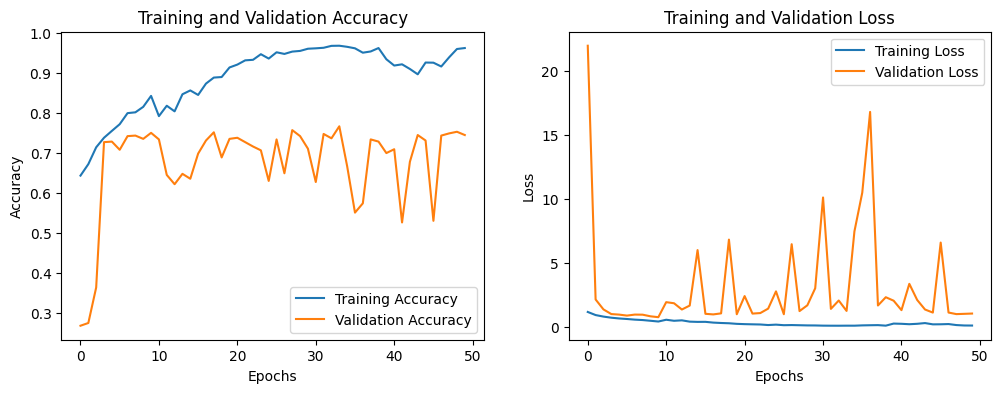

In [ ]:


# Assuming 'history' is the return value from the model.fit call
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get number of epochs

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss for Base Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:


# Load VGG16 pre-trained on ImageNet data
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16.trainable = False

# Add custom layers
x_vgg16 = base_model_vgg16.output
x_vgg16 = GlobalAveragePooling2D()(x_vgg16)
x_vgg16 = Dense(1024, activation='relu')(x_vgg16)
x_vgg16 = Dropout(0.5)(x_vgg16)
predictions_vgg16 = Dense(5, activation='softmax')(x_vgg16)

model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg16)
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:


# Load InceptionV3 pre-trained on ImageNet data
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inception.trainable = False

# Add custom layers
x_inception = base_model_inception.output
x_inception = GlobalAveragePooling2D()(x_inception)
x_inception = Dense(1024, activation='relu')(x_inception)
x_inception = Dropout(0.5)(x_inception)
predictions_inception = Dense(5, activation='softmax')(x_inception)

model_inception = Model(inputs=base_model_inception.input, outputs=predictions_inception)
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:


# Load Xception pre-trained on ImageNet data
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_xception.trainable = False

# Add custom layers
x_xception = base_model_xception.output
x_xception = GlobalAveragePooling2D()(x_xception)
x_xception = Dense(1024, activation='relu')(x_xception)
x_xception = Dropout(0.5)(x_xception)
predictions_xception = Dense(5, activation='softmax')(x_xception)

model_xception = Model(inputs=base_model_xception.input, outputs=predictions_xception)
model_xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


83683744/83683744 [==============================] - 1s 0us/step


In [ ]:


# Load MobileNetV2 pre-trained on ImageNet data
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_mobilenet.trainable = False

# Add custom layers
x_mobilenet = base_model_mobilenet.output
x_mobilenet = GlobalAveragePooling2D()(x_mobilenet)
x_mobilenet = Dense(1024, activation='relu')(x_mobilenet)
x_mobilenet = Dropout(0.5)(x_mobilenet)
predictions_mobilenet = Dense(5, activation='softmax')(x_mobilenet)

model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobilenet)
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
history_vgg16 = model_vgg16.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset
)


Epoch 1/50
92/92 [==============================] - 31s 286ms/step - loss: 0.9483 - accuracy: 0.6562 - val_loss: 0.7684 - val_accuracy: 0.7340
Epoch 2/50
92/92 [==============================] - 19s 197ms/step - loss: 0.7848 - accuracy: 0.7214 - val_loss: 0.7171 - val_accuracy: 0.7367
Epoch 3/50
92/92 [==============================] - 21s 217ms/step - loss: 0.7381 - accuracy: 0.7310 - val_loss: 0.6975 - val_accuracy: 0.7367
Epoch 4/50
92/92 [==============================] - 21s 218ms/step - loss: 0.7147 - accuracy: 0.7378 - val_loss: 0.7268 - val_accuracy: 0.7299
Epoch 5/50
92/92 [==============================] - 19s 195ms/step - loss: 0.7033 - accuracy: 0.7491 - val_loss: 0.6901 - val_accuracy: 0.7490
Epoch 6/50
92/92 [==============================] - 19s 197ms/step - loss: 0.6944 - accuracy: 0.7470 - val_loss: 0.6732 - val_accuracy: 0.7490
Epoch 7/50
92/92 [==============================] - 18s 194ms/step - loss: 0.6799 - accuracy: 0.7518 - val_loss: 0.6841 - val_accuracy: 0.7408

In [ ]:
history_xception = model_xception.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset
)


Epoch 1/50
92/92 [==============================] - 33s 294ms/step - loss: 0.9073 - accuracy: 0.6804 - val_loss: 0.7307 - val_accuracy: 0.7462
Epoch 2/50
92/92 [==============================] - 20s 208ms/step - loss: 0.7150 - accuracy: 0.7337 - val_loss: 0.6481 - val_accuracy: 0.7613
Epoch 3/50
92/92 [==============================] - 21s 225ms/step - loss: 0.7016 - accuracy: 0.7409 - val_loss: 0.6680 - val_accuracy: 0.7572
Epoch 4/50
92/92 [==============================] - 20s 205ms/step - loss: 0.6574 - accuracy: 0.7573 - val_loss: 0.6426 - val_accuracy: 0.7613
Epoch 5/50
92/92 [==============================] - 20s 215ms/step - loss: 0.6526 - accuracy: 0.7562 - val_loss: 0.6323 - val_accuracy: 0.7558
Epoch 6/50
92/92 [==============================] - 21s 221ms/step - loss: 0.6356 - accuracy: 0.7695 - val_loss: 0.6644 - val_accuracy: 0.7449
Epoch 7/50
92/92 [==============================] - 21s 216ms/step - loss: 0.6284 - accuracy: 0.7665 - val_loss: 0.6302 - val_accuracy: 0.7667

In [ ]:
history_mobilenet = model_mobilenet.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset
)


Epoch 1/50
92/92 [==============================] - 23s 199ms/step - loss: 0.9921 - accuracy: 0.6794 - val_loss: 0.7335 - val_accuracy: 0.7449
Epoch 2/50
92/92 [==============================] - 17s 182ms/step - loss: 0.7095 - accuracy: 0.7453 - val_loss: 0.6868 - val_accuracy: 0.7490
Epoch 3/50
92/92 [==============================] - 18s 194ms/step - loss: 0.6598 - accuracy: 0.7508 - val_loss: 0.6510 - val_accuracy: 0.7544
Epoch 4/50
92/92 [==============================] - 18s 186ms/step - loss: 0.6415 - accuracy: 0.7730 - val_loss: 0.6074 - val_accuracy: 0.7763
Epoch 5/50
92/92 [==============================] - 20s 206ms/step - loss: 0.6187 - accuracy: 0.7716 - val_loss: 0.6445 - val_accuracy: 0.7585
Epoch 6/50
92/92 [==============================] - 17s 182ms/step - loss: 0.5959 - accuracy: 0.7747 - val_loss: 0.6095 - val_accuracy: 0.7872
Epoch 7/50
92/92 [==============================] - 19s 198ms/step - loss: 0.5963 - accuracy: 0.7774 - val_loss: 0.6340 - val_accuracy: 0.7613

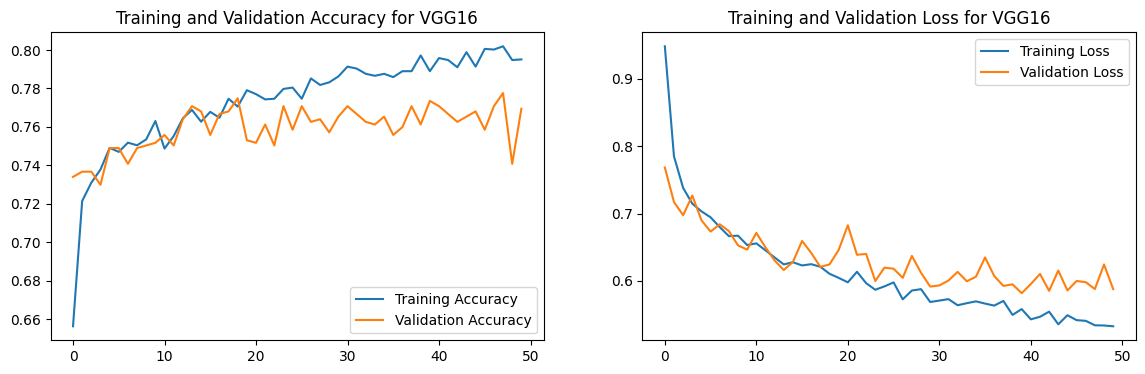

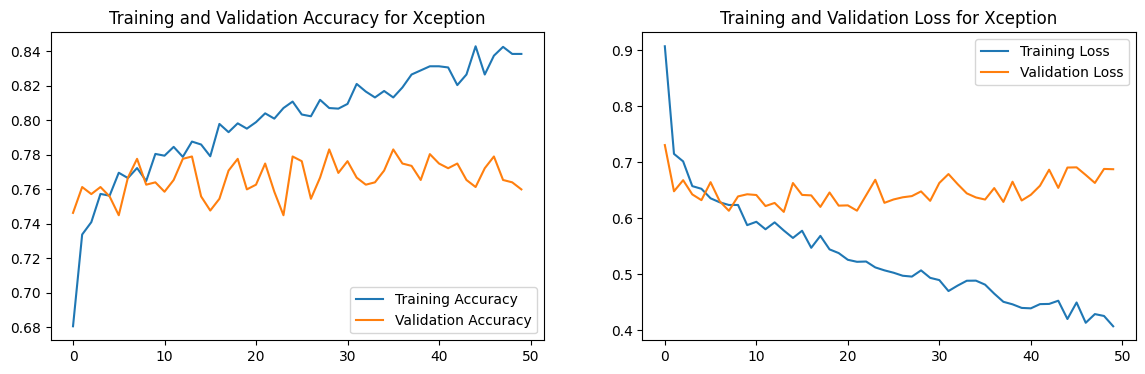

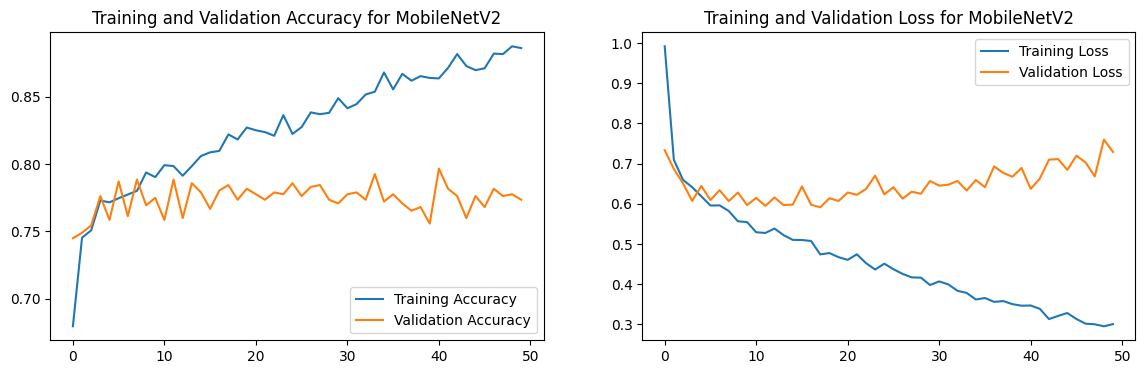

In [ ]:
def plot_model_performance(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy for {model_name}')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.legend(loc='upper right')

    plt.show()

# Plot for each model
plot_model_performance(history_vgg16, "VGG16")

plot_model_performance(history_xception, "Xception")
plot_model_performance(history_mobilenet, "MobileNetV2")


In [ ]:
# # Saving model1
# model1.save('/content/drive/MyDrive/Rotation/Models/Gaussian/base_model_g.h5')

# # Saving VGG16 Model
# model_vgg16.save('/content/drive/MyDrive/Rotation/Models/Gaussian/vgg16_model_g.h5')

# # Saving InceptionV3 Model
# model_inception.save('/content/drive/MyDrive/Rotation/Models/Gaussian/inception_model_g.h5')

# # Saving Xception Model
# model_xception.save('/content/drive/MyDrive/Rotation/Models/Gaussian/xception_model_g.h5')

# # Saving MobileNetV2 Model
# model_mobilenet.save('/content/drive/MyDrive/Rotation/Models/Gaussian/mobilenet_model_g.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
model_vgg16 = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/vgg16_model_g.h5')
model_vgg16._name = 'VGG16'

model_inception = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/inception_model_g.h5')
model_inception._name = 'InceptionV3'

model_xception = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/xception_model_g.h5')
model_xception._name = 'Xception'

model_mobilenet = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/mobilenet_model_g.h5')
model_mobilenet._name = 'MobileNetV2'

model1 = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/base_model_g.h5')
model1._name = 'CustomModel1'

# Evaluate the models
vgg16_eval = model_vgg16.evaluate(validation_dataset)
inception_eval = model_inception.evaluate(validation_dataset)
xception_eval = model_xception.evaluate(validation_dataset)
mobilenet_eval = model_mobilenet.evaluate(validation_dataset)
model1_eval = model1.evaluate(validation_dataset)

print("VGG16 Accuracy:", vgg16_eval[1])
print("InceptionV3 Accuracy:", inception_eval[1])
print("Xception Accuracy:", xception_eval[1])
print("MobileNetV2 Accuracy:", mobilenet_eval[1])
print("Model1 Accuracy:", model1_eval[1])


23/23 [==============================] - 4s 125ms/step - loss: 1.0518 - accuracy: 0.7408
VGG16 Accuracy: 0.7653478980064392
InceptionV3 Accuracy: 0.09276944398880005
Xception Accuracy: 0.761255145072937
MobileNetV2 Accuracy: 0.7721691727638245
Model1 Accuracy: 0.7407912611961365


In [ ]:
image_info = [
    {'path': '/content/drive/MyDrive/Rotation/gaussian/val/Mild/01b3aed3ed4c.png', 'original_class': 'Mild'},
    {'path': '/content/drive/MyDrive/Rotation/gaussian/val/Moderate/00e4ddff966a.png', 'original_class': 'Moderate'},
    {'path': '/content/drive/MyDrive/Rotation/gaussian/val/No_DR/005b95c28852.png', 'original_class': 'No_DR'}
    # Add more images and their classes as needed
]




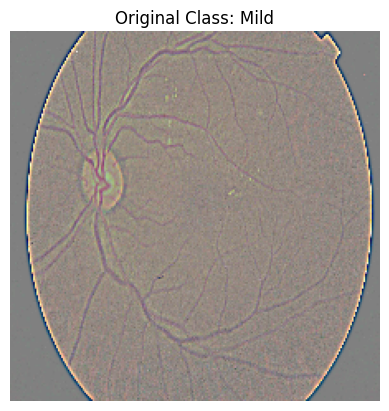

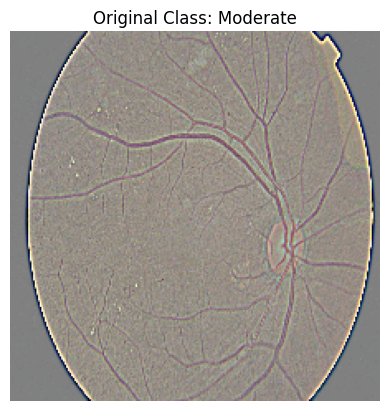

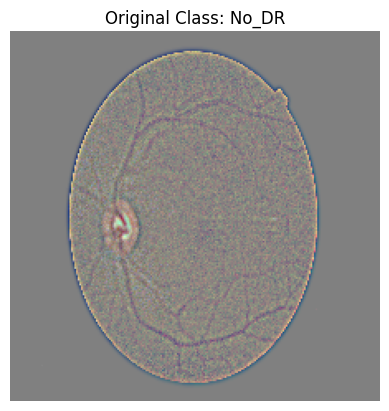

In [ ]:
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Normalize to [0,1]
    return img, img_array

# Display each image with its original class
for info in image_info:
    img, _ = load_and_preprocess_image(info['path'])
    plt.imshow(img)
    plt.title(f"Original Class: {info['original_class']}")
    plt.axis('off')
    plt.show()


In [ ]:
# Assuming class_names and image_info are already defined
# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Normalize to [0,1]
    return img_array

class_names = {
    0: 'Mild',
    1: 'Moderate',
    2: 'No_DR',
    3: 'Proliferate_DR',
    4: 'Severe'
}

# Assuming class_names and image_info are already defined

# Loop through each model and each image, make predictions, and compare with the original class
for model in [model_vgg16, model_inception, model_xception, model_mobilenet, model1]:
    correct_predictions = 0
    total_images = len(image_info)

    print(f"\nPredictions using {model.name}:")
    for info in image_info:
        img = load_and_preprocess_image(info['path'])
        prediction = model.predict(img)
        predicted_class_index = np.argmax(prediction, axis=1)[0]  # Assuming a single prediction
        predicted_class_name = class_names[predicted_class_index]

        # Compare the predicted class with the original class
        if predicted_class_name == info['original_class']:
            correct_predictions += 1
            result = "Correct"
        else:
            result = "Wrong"
        print(f"Original Class: {info['original_class']}, Predicted Class: {predicted_class_name} - {result}")

    # Print the summary for each model
    print(f"Out of {total_images} images, {correct_predictions} are correct.")




Predictions using VGG16:
1/1 [==============================] - 1s 777ms/step
Original Class: Mild, Predicted Class: No_DR - Wrong
1/1 [==============================] - 1s 577ms/step
Original Class: Moderate, Predicted Class: No_DR - Wrong
1/1 [==============================] - 0s 485ms/step
Original Class: No_DR, Predicted Class: No_DR - Correct
Out of 3 images, 1 are correct.

Predictions using InceptionV3:
1/1 [==============================] - 2s 2s/step
Original Class: Mild, Predicted Class: Severe - Wrong
1/1 [==============================] - 0s 134ms/step
Original Class: Moderate, Predicted Class: Severe - Wrong
1/1 [==============================] - 0s 133ms/step
Original Class: No_DR, Predicted Class: Severe - Wrong
Out of 3 images, 0 are correct.

Predictions using Xception:
1/1 [==============================] - 1s 1s/step
Original Class: Mild, Predicted Class: No_DR - Wrong
1/1 [==============================] - 0s 316ms/step
Original Class: Moderate, Predicted Class: No

1/1 [==============================] - 0s 268ms/step
Original Class: Mild, Predicted Class: No_DR - Wrong
1/1 [==============================] - 0s 96ms/step
Original Class: Moderate, Predicted Class: No_DR - Wrong
1/1 [==============================] - 0s 93ms/step
Original Class: No_DR, Predicted Class: No_DR - Correct
Out of 3 images, 1 are correct.


In [ ]:
# model_vgg16 = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/vgg16_model_g.h5')
# model_vgg16._name = 'VGG16'

model_xception = load_model('/content/drive/MyDrive/Rotation/Models/Gaussian/xception_model_g.h5')
model_xception._name = 'Xception'

def preprocess_input_custom(x):
    return preprocess_input(x)

model = model_xception

gradcam = Gradcam(model, model_modifier=None, clone=True)
gradcam_plus_plus = GradcamPlusPlus(model, model_modifier=None, clone=True)
saliency = Saliency(model, model_modifier=None, clone=True)


1/1 [==============================] - 0s 208ms/step


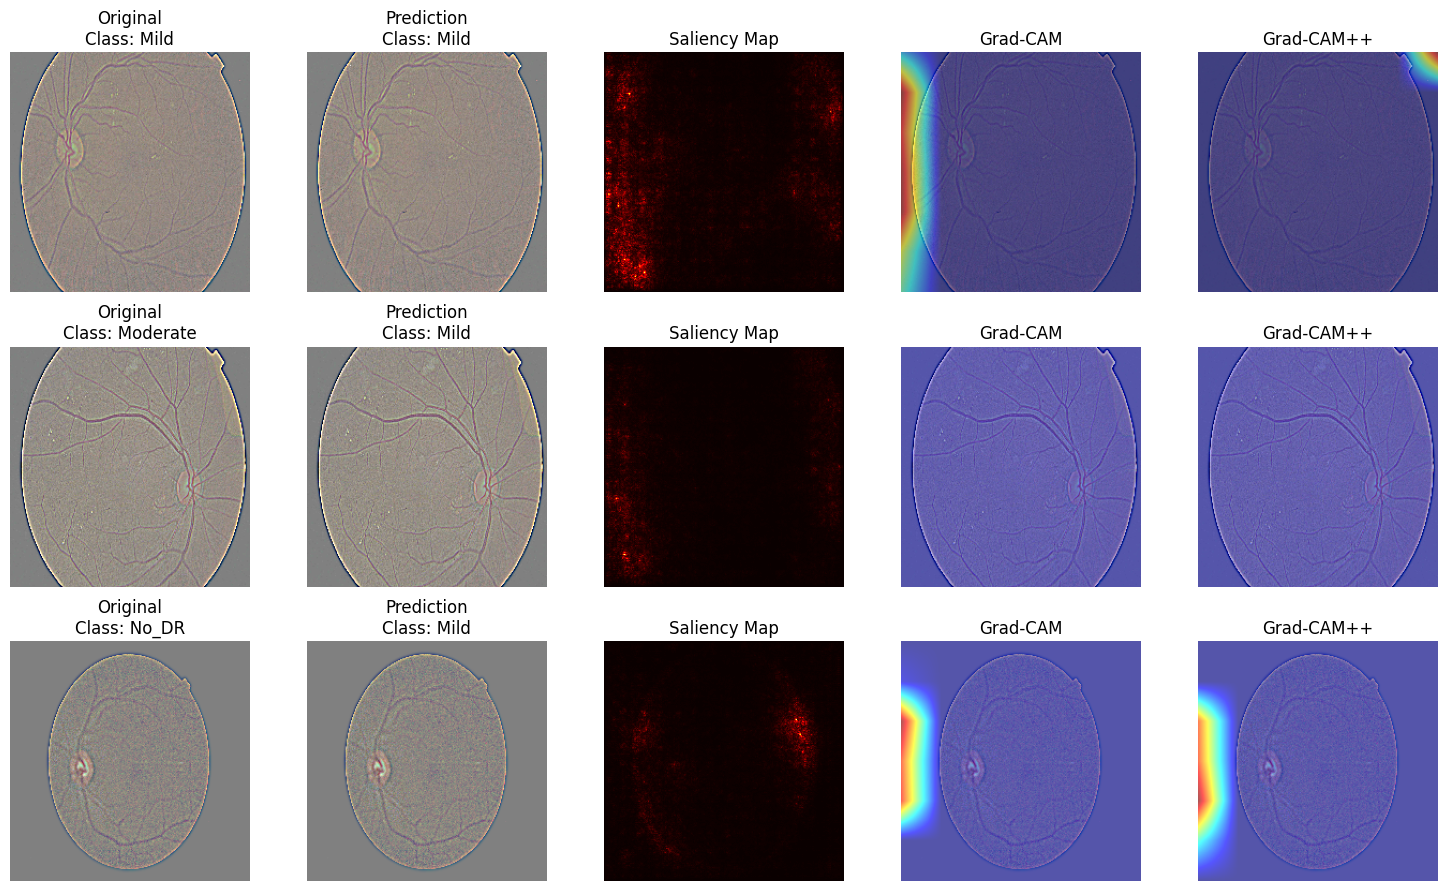

In [ ]:
class_names = {
    0: 'Mild',
    1: 'Moderate',
    2: 'No_DR',
    3: 'Proliferate_DR',
    4: 'Severe'
}

image_info = [
    {'path': '/content/drive/MyDrive/Rotation/gaussian/val/Mild/01b3aed3ed4c.png', 'original_class': 'Mild'},
    {'path': '/content/drive/MyDrive/Rotation/gaussian/val/Moderate/00e4ddff966a.png', 'original_class': 'Moderate'},
    {'path': '/content/drive/MyDrive/Rotation/gaussian/val/No_DR/005b95c28852.png', 'original_class': 'No_DR'}
    # Add more images and their classes as needed
]


fig, axs = plt.subplots(len(image_info), 5, figsize=(15, len(image_info) * 3), squeeze=False)

for i, info in enumerate(image_info):
    img_path = info['path']
    original_class = info['original_class']

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_custom(x)

    prediction = model.predict(x)
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    try:
        predicted_class = class_names[predicted_class_index]
    except KeyError:
        print(f"Invalid class index: {predicted_class_index}")
        continue

    def score_function(output):
        return output[0][predicted_class_index]


    cam = gradcam(score_function, x, penultimate_layer=None)  # Replace None with your model layer
    cam = normalize(cam)

    cam_plus_plus = gradcam_plus_plus(score_function, x, penultimate_layer=None)  # Replace None with your model layer
    cam_plus_plus = normalize(cam_plus_plus)

    saliency_map = saliency(score_function, x)
    saliency_map = normalize(saliency_map)

    # Heatmap generation
    heatmap = cv2.applyColorMap(np.uint8(255 * cam[0]), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    img_with_heatmap = np.float32(heatmap) + np.float32(img)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)

    heatmap_plus_plus = cv2.applyColorMap(np.uint8(255 * cam_plus_plus[0]), cv2.COLORMAP_JET)
    heatmap_plus_plus = cv2.cvtColor(heatmap_plus_plus, cv2.COLOR_BGR2RGB)
    img_with_heatmap_plus_plus = np.float32(heatmap_plus_plus) + np.float32(img)
    img_with_heatmap_plus_plus = img_with_heatmap_plus_plus / np.max(img_with_heatmap_plus_plus)

    # Displaying images and maps
    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f'Original\nClass: {original_class}')

    axs[i, 1].imshow(img)
    axs[i, 1].axis('off')
    axs[i, 1].set_title(f'Prediction\nClass: {predicted_class}')

    axs[i, 2].imshow(saliency_map[0], cmap='hot')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Saliency Map')

    axs[i, 3].imshow(img_with_heatmap)
    axs[i, 3].axis('off')
    axs[i, 3].set_title('Grad-CAM')

    axs[i, 4].imshow(img_with_heatmap_plus_plus)
    axs[i, 4].axis('off')
    axs[i, 4].set_title('Grad-CAM++')

plt.tight_layout()
plt.show()



In [ ]:
# Load and preprocess image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Normalize to [0,1]
    return img_array


def grad_cam(input_model, image, layer_name, H=224, W=224):
    # Get the convolutional layer and make a model ending at that layer
    conv_layer = input_model.get_layer(layer_name)
    model_with_conv_output = tf.keras.Model(inputs=input_model.inputs, outputs=[conv_layer.output, input_model.output])

    # Predict class and get layer output
    with tf.GradientTape() as tape:
        conv_output, predictions = model_with_conv_output(image)
        class_idx = np.argmax(predictions[0])
        class_output = predictions[:, class_idx]

    # Compute gradients
    grads = tape.gradient(class_output, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output with the computed gradients
    conv_output = conv_output[0]
    cam = np.dot(conv_output, pooled_grads[..., tf.newaxis])
    cam = tf.squeeze(cam).numpy()
    cam = np.maximum(cam, 0)  # Apply ReLU
    cam = zoom(cam, (H / cam.shape[0], W / cam.shape[1]))  # Resize to input image size
    cam /= np.max(cam)  # Normalize
    return cam


def grad_cam_plus(model, img_array, layer_name, H=224, W=224):
    # Get the index of the class with the highest score in the prediction
    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])

    # Get the output of the targeted layer
    target_layer = model.get_layer(layer_name).output

    # Set up a model that returns the target layer's output and the overall model's output
    sub_model = tf.keras.models.Model(inputs=model.inputs, outputs=[target_layer, model.output])

    with tf.GradientTape() as tape:
        # Watch the activations of the target layer
        conv_outputs, predictions = sub_model(img_array)
        loss = predictions[:, class_idx]

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the target layer
    grads = tape.gradient(loss, conv_outputs)

    # Ensure the gradients are not None
    if grads is None:
        raise ValueError(f"No gradients found for layer {layer_name}")

    # Compute guided gradients
    cast_conv_outputs = tf.cast(conv_outputs > 0, "float32")
    cast_grads = tf.cast(grads > 0, "float32")
    guided_grads = cast_conv_outputs * cast_grads * grads

    # Average the gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Build a map of activations based on the weights
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    cam = np.maximum(cam, 0)  # Apply ReLU
    cam = zoom(cam[0], (H / cam.shape[0], W / cam.shape[1]))
    cam = cam / np.max(cam)  # Normalize
    return cam




In [ ]:
for layer in model.layers:
    print(layer.name)



input_3
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d_97
block2_pool
batch_normalization_98
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_98
block3_pool
batch_normalization_99
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_99
block4_pool
batch_normalization_100
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
block

1/1 [==============================] - 0s 235ms/step


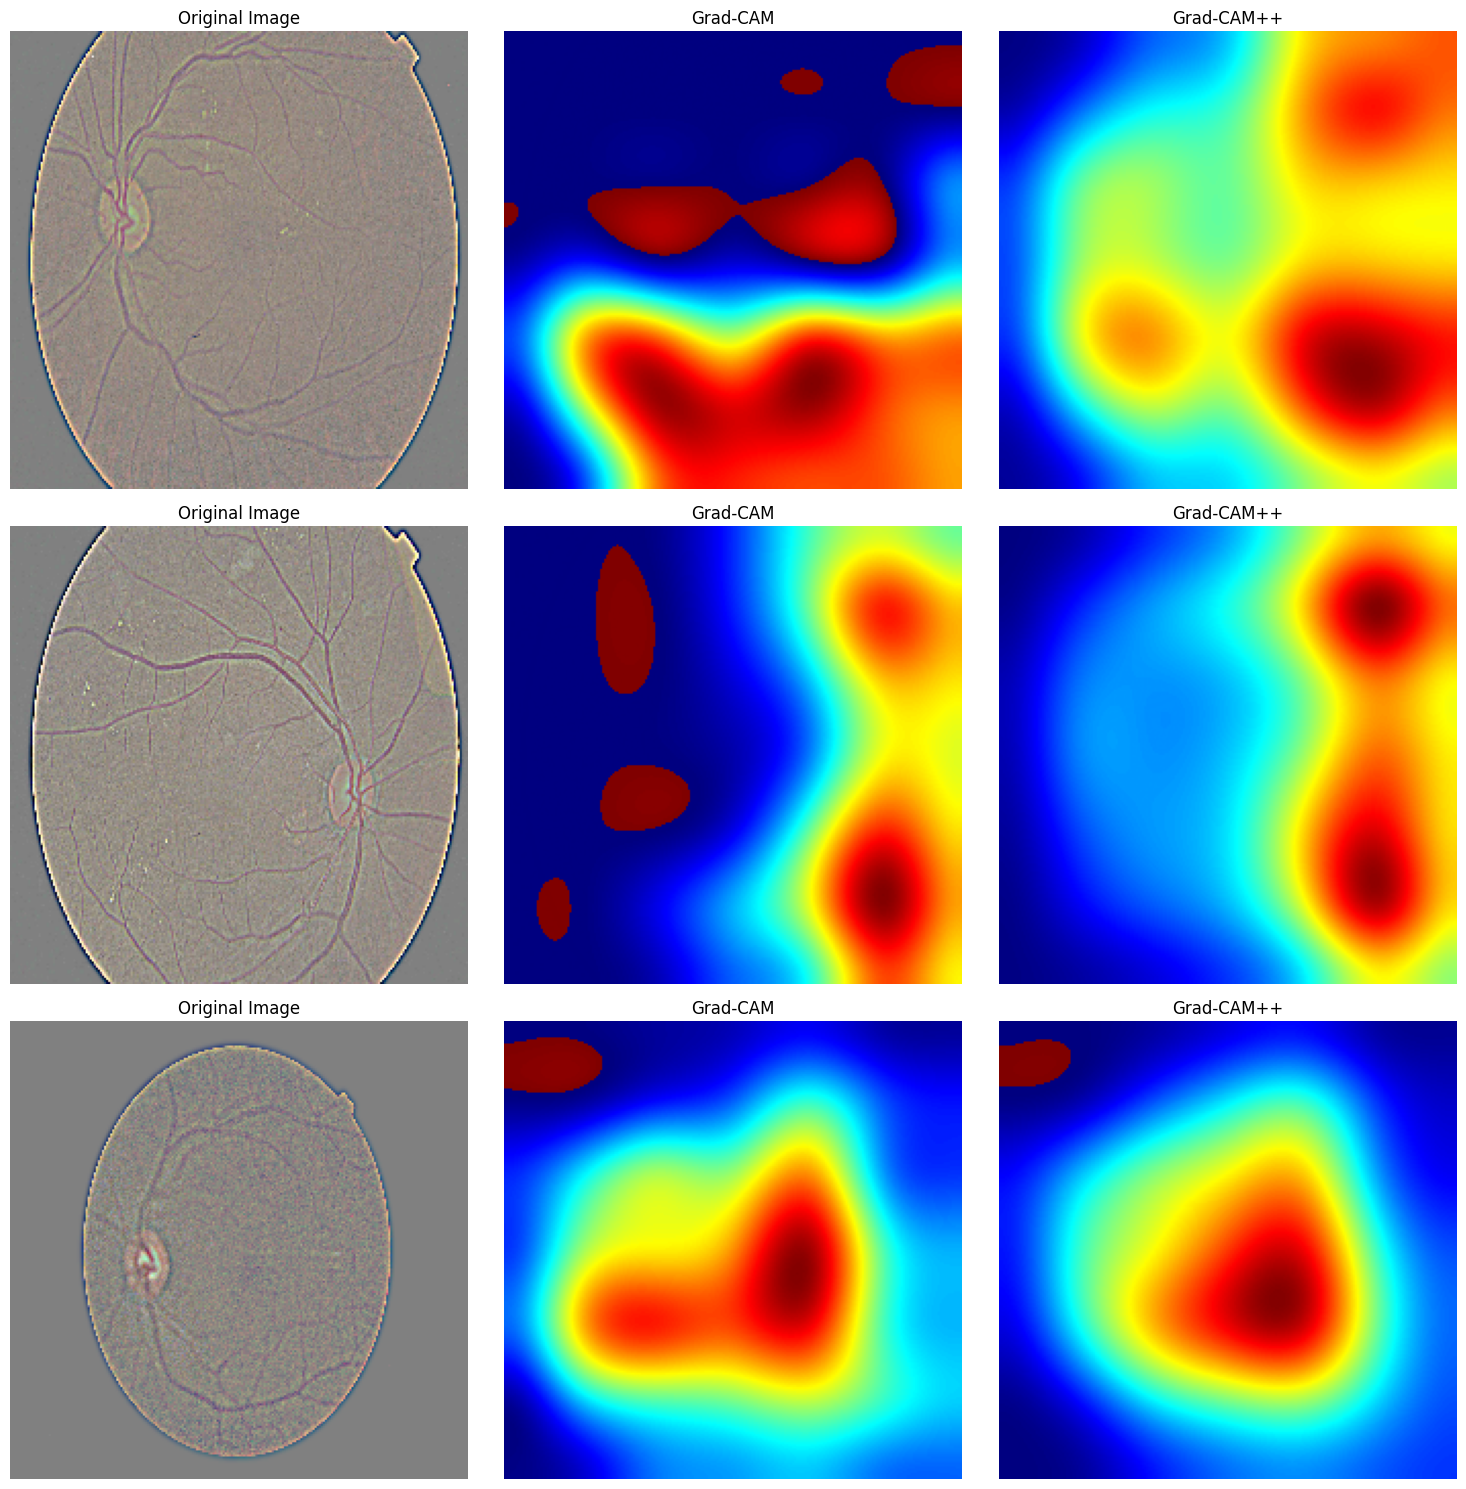

In [ ]:
# Layer name for visualization
layer_name = 'block14_sepconv2_act'


# Set up subplot dimensions
fig, axs = plt.subplots(len(image_info), 3, figsize=(15, len(image_info) * 5))

for i, info in enumerate(image_info):
    img_path = info['path']
    img = load_and_preprocess_image(img_path)

    # Grad-CAM
    cam = grad_cam(model, img, layer_name)
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    cam_heatmap_resized = cv2.resize(cam_heatmap, (img[0].shape[1], img[0].shape[0]))
    img_with_cam = np.float32(cam_heatmap_resized) + np.float32(img[0])
    img_with_cam = img_with_cam / np.max(img_with_cam)

    # Grad-CAM++
    cam_plus = grad_cam_plus(model, img, layer_name)
    cam_plus_heatmap = cv2.applyColorMap(np.uint8(255 * cam_plus), cv2.COLORMAP_JET)
    cam_plus_heatmap = cv2.cvtColor(cam_plus_heatmap, cv2.COLOR_BGR2RGB)
    cam_plus_heatmap_resized = cv2.resize(cam_plus_heatmap, (img[0].shape[1], img[0].shape[0]))
    img_with_cam_plus = np.float32(cam_plus_heatmap_resized) + np.float32(img[0])
    img_with_cam_plus = img_with_cam_plus / np.max(img_with_cam_plus)

    # Plot original image
    axs[i, 0].imshow(img[0])
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original Image')

    # Plot Grad-CAM heatmap
    axs[i, 1].imshow(img_with_cam)
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Grad-CAM')

    # Plot Grad-CAM++ heatmap
    axs[i, 2].imshow(img_with_cam_plus)
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Grad-CAM++')

plt.tight_layout()
plt.show()


In [4]:
# Function to extract true labels from the validation dataset
def get_true_labels(validation_dataset):
    true_labels = []
    for images, labels in validation_dataset:
        true_labels.extend(labels.numpy().argmax(axis=1))
    return np.array(true_labels)

# Function to predict labels using a model
def predict(model, validation_dataset):
    predictions = model.predict(validation_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

# Get true labels
true_labels = get_true_labels(validation_dataset)




(733,)

23/23 [==============================] - 4s 169ms/step


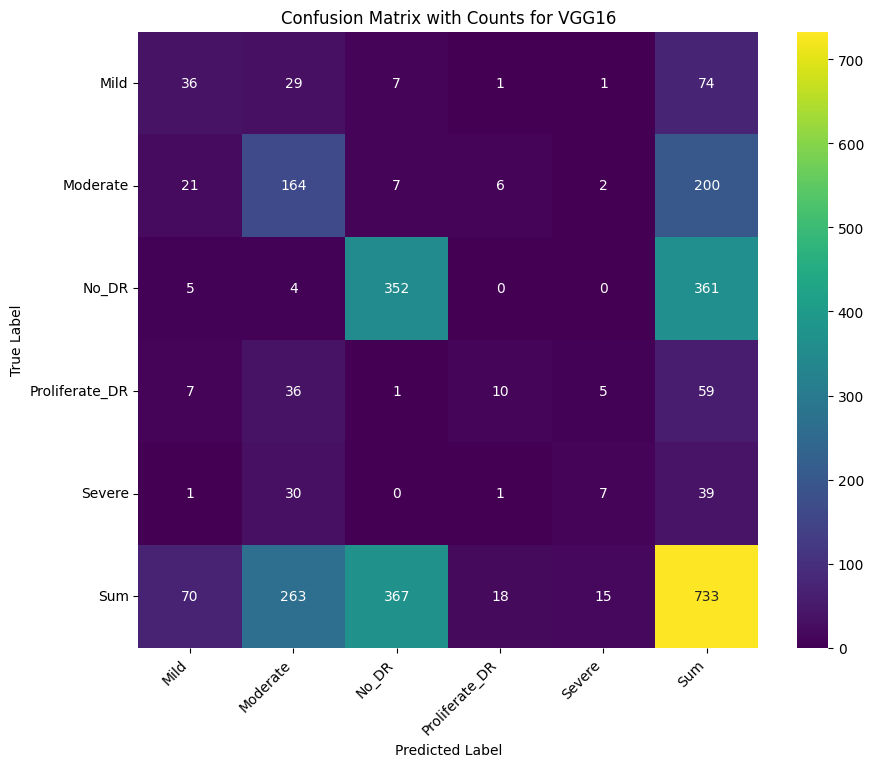

23/23 [==============================] - 4s 170ms/step


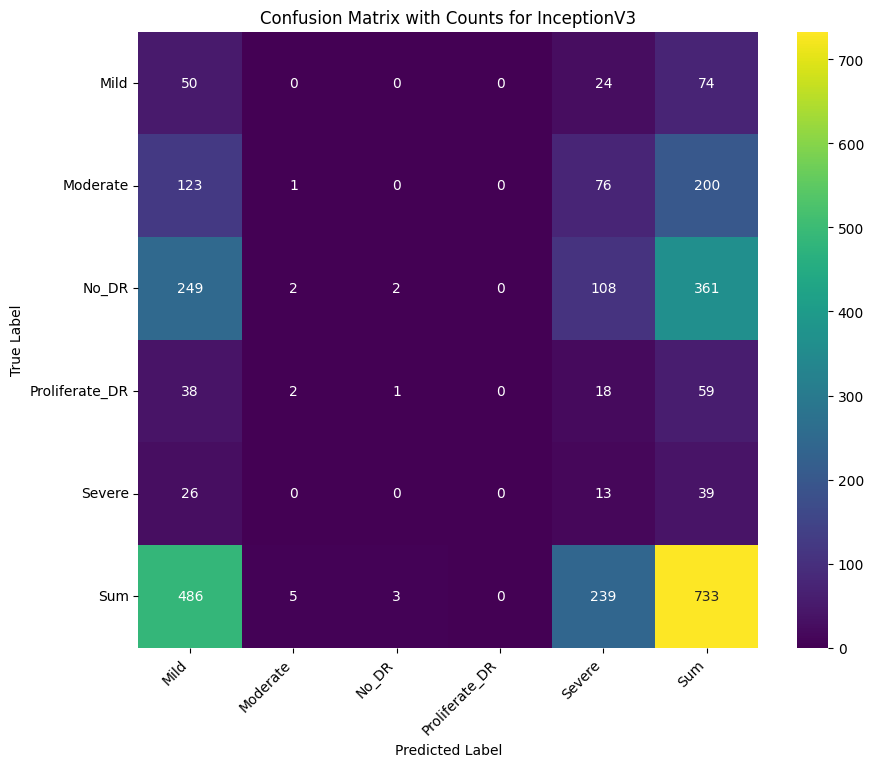

23/23 [==============================] - 4s 180ms/step


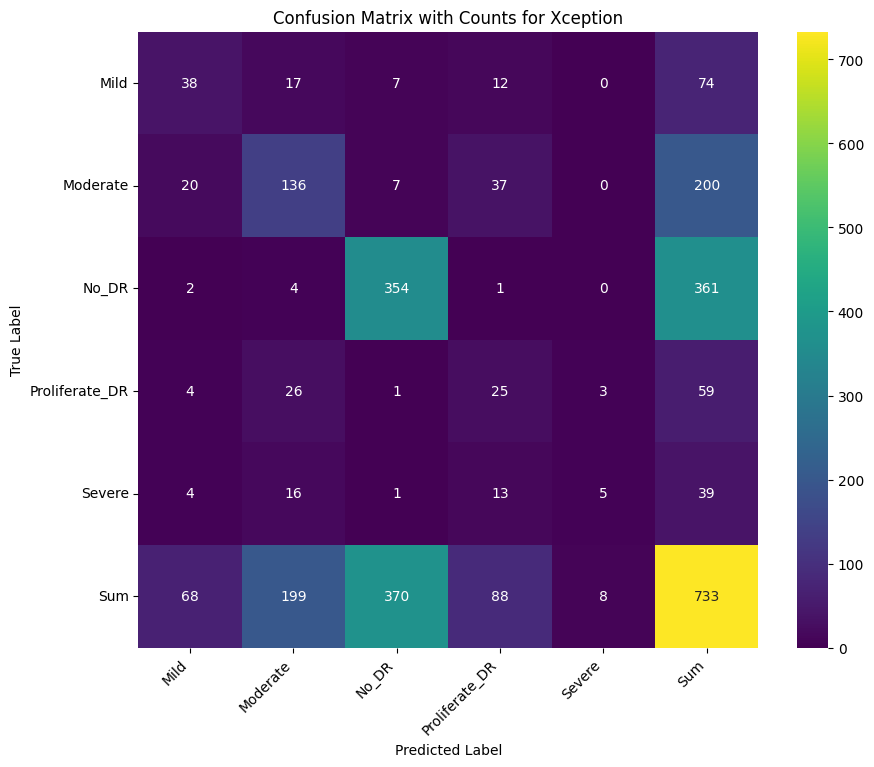

23/23 [==============================] - 3s 126ms/step


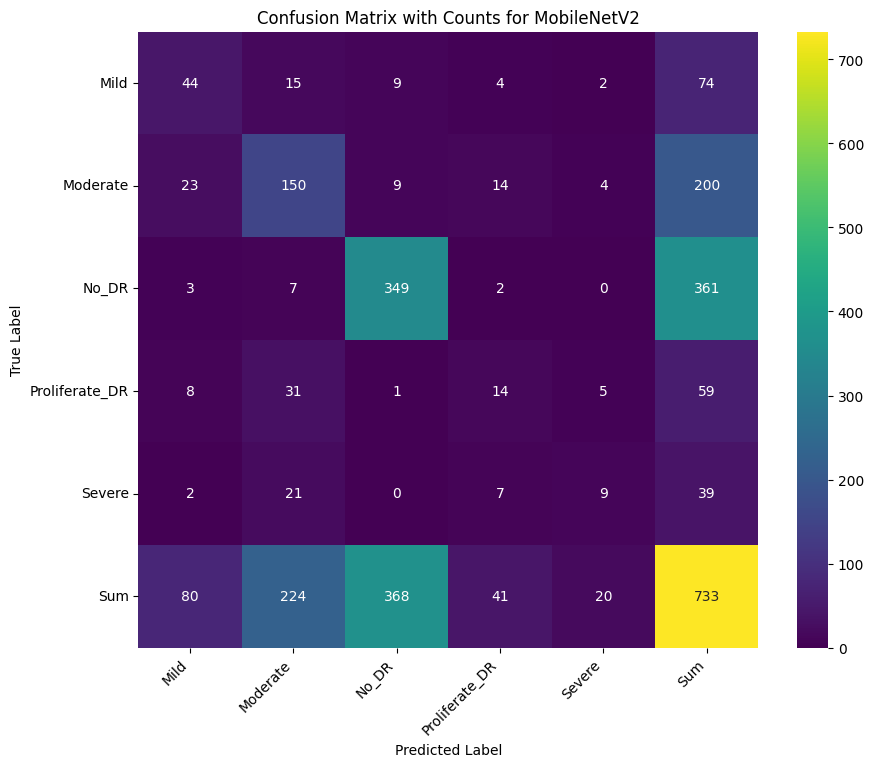

23/23 [==============================] - 3s 126ms/step


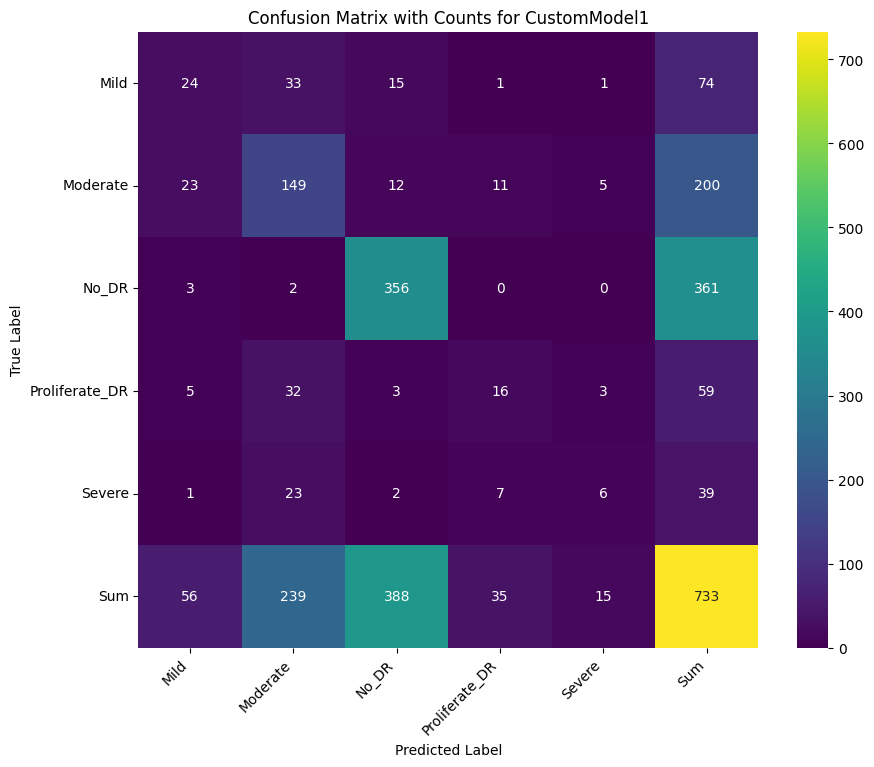

In [10]:
class_names = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]

# Models
models = {
    'VGG16': model_vgg16,
    'InceptionV3': model_inception,
    'Xception': model_xception,
    'MobileNetV2': model_mobilenet,
    'CustomModel1': model1
}

# Function to predict labels using a model
def predict(model, validation_dataset):
    predictions = model.predict(validation_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels

# Iterate over models and plot confusion matrices
for model_name, model in models.items():
    predictions = predict(model, validation_dataset)
    cm = confusion_matrix(true_labels, predictions, labels=range(len(class_names)))
    cm_with_counts = np.c_[cm, cm.sum(axis=1)]
    cm_with_counts = np.r_[cm_with_counts, [cm_with_counts.sum(axis=0)]]

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm_with_counts, annot=True, fmt='g', cmap='viridis')
    ax.set_title(f'Confusion Matrix with Counts for {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Set the class names as tick labels
    ax.set_xticklabels(class_names + ['Sum'], rotation=45, ha="right")
    ax.set_yticklabels(class_names + ['Sum'], rotation=0)
    plt.show()


In [8]:
# Function to calculate class-wise metrics
def calculate_metrics(true_labels, predictions, num_classes):
    precision = precision_score(true_labels, predictions, average=None, labels=range(num_classes))
    recall = recall_score(true_labels, predictions, average=None, labels=range(num_classes))
    f1 = f1_score(true_labels, predictions, average=None, labels=range(num_classes))

    # For class-wise accuracy, we'll calculate manually
    cm = confusion_matrix(true_labels, predictions, labels=range(num_classes))
    class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

    metrics = pd.DataFrame({
        'Accuracy': class_wise_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, index=[f'Class {i}' for i in range(num_classes)])

    return metrics

# Assuming you have 5 classes in your dataset
num_classes = 5

# Metrics for each model
model_metrics = {}

for model_name, model in models.items():
    predictions = predict(model, validation_dataset)
    metrics = calculate_metrics(true_labels, predictions, num_classes)
    model_metrics[model_name] = metrics

# Display the metrics for each model
for model_name, metrics in model_metrics.items():
    print(f"Metrics for {model_name}:")
    print(metrics, "\n")


23/23 [==============================] - 5s 213ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


23/23 [==============================] - 3s 123ms/step
Metrics for VGG16:
         Accuracy  Precision    Recall  F1 Score
Class 0  0.486486   0.507042  0.486486  0.496552
Class 1  0.820000   0.623574  0.820000  0.708423
Class 2  0.975069   0.959128  0.975069  0.967033
Class 3  0.152542   0.500000  0.152542  0.233766
Class 4  0.179487   0.500000  0.179487  0.264151 

Metrics for InceptionV3:
         Accuracy  Precision    Recall  F1 Score
Class 0  0.689189   0.101796  0.689189  0.177391
Class 1  0.000000   0.000000  0.000000  0.000000
Class 2  0.008310   1.000000  0.008310  0.016484
Class 3  0.000000   0.000000  0.000000  0.000000
Class 4  0.435897   0.074890  0.435897  0.127820 

Metrics for Xception:
         Accuracy  Precision    Recall  F1 Score
Class 0  0.527027   0.534247  0.527027  0.530612
Class 1  0.650000   0.687831  0.650000  0.668380
Class 2  0.977839   0.951482  0.977839  0.964481
Class 3  0.474576   0.311111  0.474576  0.375839
Class 4  0.128205   0.500000  0.128205  0.

In [9]:
# Function to calculate specificity
def specificity(true_labels, predictions, num_classes):
    cm = confusion_matrix(true_labels, predictions, labels=range(num_classes))
    tn = cm.diagonal()
    fp = cm.sum(axis=0) - tn
    fn = cm.sum(axis=1) - tn
    spec = tn / (tn + fp)
    return spec

# Function to calculate class-wise metrics
def calculate_metrics(true_labels, predictions, num_classes, class_names):
    precision = precision_score(true_labels, predictions, average=None, labels=range(num_classes))
    recall = recall_score(true_labels, predictions, average=None, labels=range(num_classes))
    f1 = f1_score(true_labels, predictions, average=None, labels=range(num_classes))
    spec = specificity(true_labels, predictions, num_classes)

    # For class-wise accuracy, we'll calculate manually
    cm = confusion_matrix(true_labels, predictions, labels=range(num_classes))
    class_wise_accuracy = cm.diagonal() / cm.sum(axis=1)

    metrics = pd.DataFrame({
        'Accuracy': class_wise_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Specificity': spec
    }, index=class_names)

    return metrics

# Class names
class_names = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]
num_classes = len(class_names)

# Metrics for each model
model_metrics = {}

for model_name, model in models.items():
    predictions = predict(model, validation_dataset)
    metrics = calculate_metrics(true_labels, predictions, num_classes, class_names)
    model_metrics[model_name] = metrics

# Display the metrics for each model
for model_name, metrics in model_metrics.items():
    print(f"Metrics for {model_name}:")
    print(metrics, "\n")


23/23 [==============================] - 3s 139ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-ba50bae0a1fc>:10: RuntimeWarning: invalid value encountered in divide
  spec = tn / (tn + fp)


23/23 [==============================] - 3s 124ms/step
Metrics for VGG16:
                Accuracy  Precision    Recall  F1 Score  Specificity
Mild            0.472973   0.472973  0.472973  0.472973     0.472973
Moderate        0.800000   0.613027  0.800000  0.694143     0.613027
No_DR           0.977839   0.964481  0.977839  0.971114     0.964481
Proliferate_DR  0.152542   0.500000  0.152542  0.233766     0.500000
Severe          0.153846   0.428571  0.153846  0.226415     0.428571 

Metrics for InceptionV3:
                Accuracy  Precision    Recall  F1 Score  Specificity
Mild            0.648649   0.099174  0.648649  0.172043     0.099174
Moderate        0.005000   0.333333  0.005000  0.009852     0.333333
No_DR           0.002770   0.500000  0.002770  0.005510     0.500000
Proliferate_DR  0.000000   0.000000  0.000000  0.000000          NaN
Severe          0.358974   0.057377  0.358974  0.098940     0.057377 

Metrics for Xception:
                Accuracy  Precision    Recall  

23/23 [==============================] - 4s 180ms/step


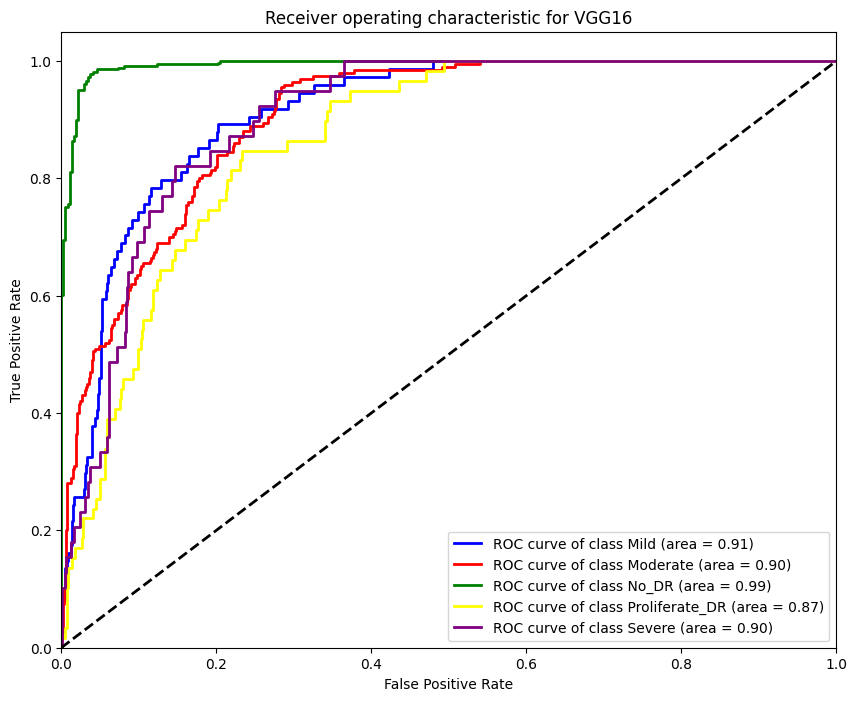

23/23 [==============================] - 8s 352ms/step


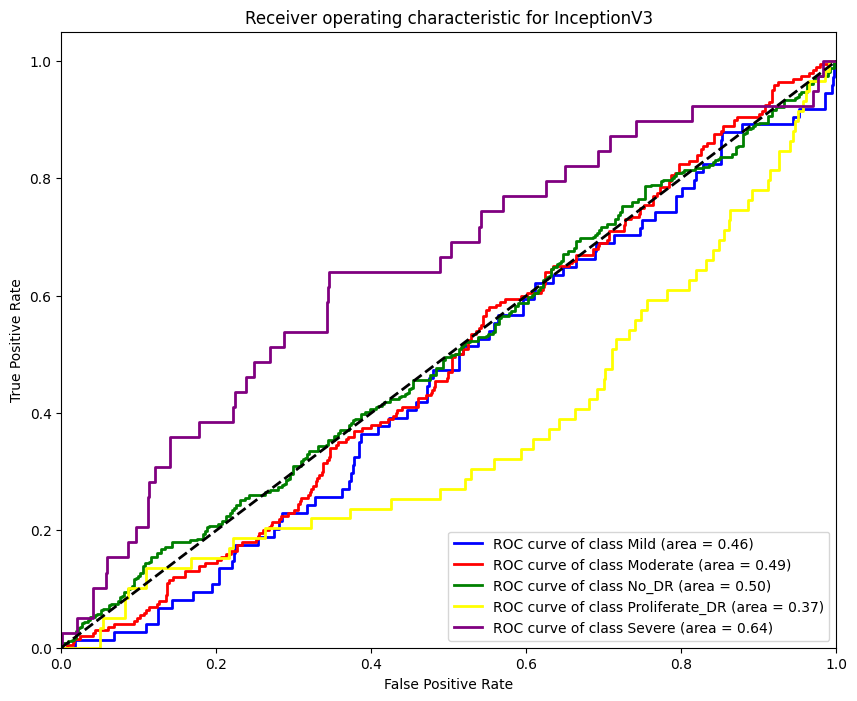

23/23 [==============================] - 4s 156ms/step


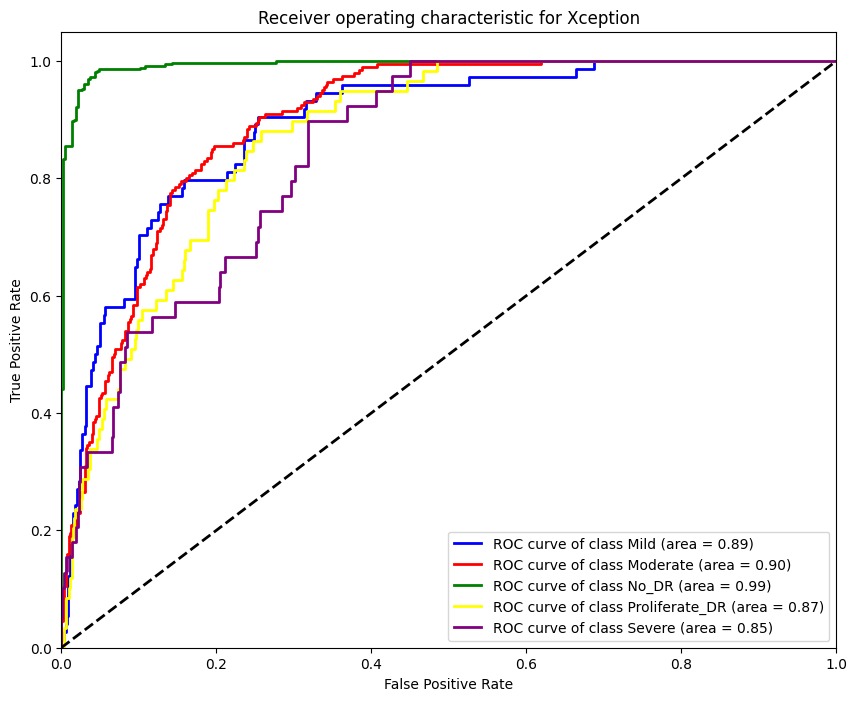

23/23 [==============================] - 5s 204ms/step


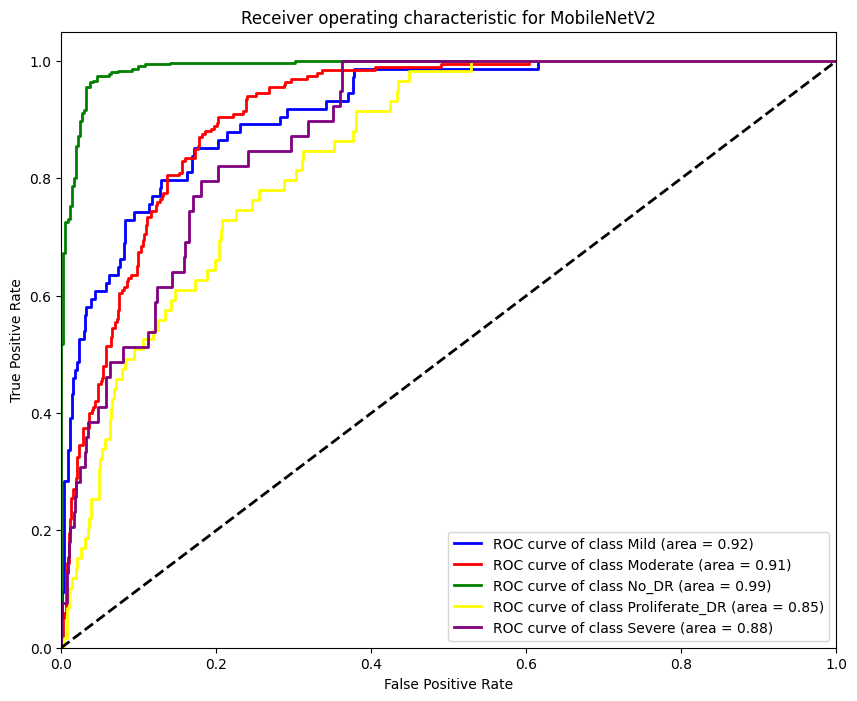

23/23 [==============================] - 3s 127ms/step


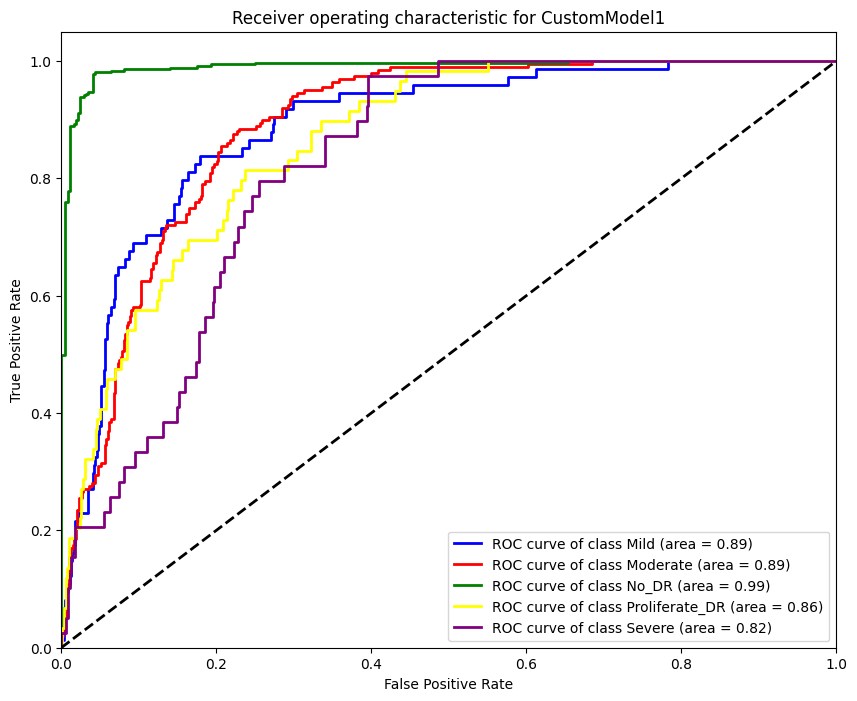

In [13]:
# Class names and number of classes
class_names = ["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"]
n_classes = len(class_names)

# Models
models = {
    'VGG16': model_vgg16,
    'InceptionV3': model_inception,
    'Xception': model_xception,
    'MobileNetV2': model_mobilenet,
    'CustomModel1': model1
}

# Function to plot ROC curve
def plot_roc_curve(y_test, y_score, n_classes, class_names, model_name):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=range(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

# Iterate over models and plot ROC curve
for model_name, model in models.items():
    # Get true labels and predictions
    y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
    y_true = np.argmax(y_true, axis=1)
    y_score = model.predict(validation_dataset)

    plot_roc_curve(y_true, y_score, n_classes, class_names, model_name)


In [14]:
# Assuming 'accuracies' is a dictionary containing model names as keys and lists of accuracies for each class as values
accuracies = {
    'VGG16': [0.472973, 0.800000, 0.977839, 0.152542, 0.153846],
    'InceptionV3': [0.648649, 0.005000, 0.002770, 0.000000, 0.358974],
    'Xception': [0.527027, 0.690000, 0.977839, 0.491525, 0.128205],
    'MobileNetV2': [0.621622, 0.760000, 0.969529, 0.220339, 0.230769],
    'CustomModel1': [0.283784, 0.735000, 0.983380, 0.288136, 0.128205]
}

# Perform ANOVA
f_statistic, p_value = f_oneway(*accuracies.values())
print(f"F-statistic: {f_statistic}, P-value: {p_value}")

# Interpretation of the result
if p_value < 0.05:
    print("There is a statistically significant difference between the models.")
else:
    print("There is no statistically significant difference between the models.")


F-statistic: 1.0028579018603705, P-value: 0.4292732251069042
There is no statistically significant difference between the models.


In [16]:

df = pd.DataFrame({
    'Model': ['VGG16', 'InceptionV3', 'Xception', 'MobileNetV2', 'CustomModel1'],
    'Accuracy': [0.472973, 0.648649, 0.527027, 0.621622, 0.283784],
    'Precision': [0.472973, 0.099174, 0.527027, 0.554217, 0.381818],
    'Recall': [0.472973, 0.648649, 0.527027, 0.621622, 0.283784],
    'F1 Score': [0.472973, 0.172043, 0.527027, 0.585987, 0.325581],
    'Specificity': [0.472973, 0.099174, 0.527027, 0.554217, 0.381818],
    'Gini Coefficient': [1.054054, 0.702702, 0.945946, 0.756756, 1.432432]
})

# Calculate statistical measures
print("Descriptive statistics of the DataFrame:")
print(df.describe())

# Calculate correlation matrix
print("Correlation matrix of the DataFrame:")
print(df.corr())


Descriptive statistics of the DataFrame:
       Accuracy  Precision    Recall  F1 Score  Specificity  Gini Coefficient
count  5.000000   5.000000  5.000000  5.000000     5.000000          5.000000
mean   0.510811   0.407042  0.510811  0.416722     0.407042          0.978378
std    0.145357   0.184271  0.145357  0.167449     0.184271          0.290713
min    0.283784   0.099174  0.283784  0.172043     0.099174          0.702702
25%    0.472973   0.381818  0.472973  0.325581     0.381818          0.756756
50%    0.527027   0.472973  0.527027  0.472973     0.472973          0.945946
75%    0.621622   0.527027  0.621622  0.527027     0.527027          1.054054
max    0.648649   0.554217  0.648649  0.585987     0.554217          1.432432
Correlation matrix of the DataFrame:
                  Accuracy  Precision    Recall  F1 Score  Specificity  \
Accuracy          1.000000  -0.195537  1.000000  0.055281    -0.195537   
Precision        -0.195537   1.000000 -0.195537  0.968072     1.000000  

<ipython-input-16-6260a27394b0>:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr())
